In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
#from SEMPIDataLoader import ListenerSpeakerFeatureDataset
from multimodal_xattention import EarlyFusion

import numpy as np
from types import SimpleNamespace

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

d:\software\Anaconda\envs\eng_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

META_DATA_COLUMNS = ['frame', 'face_id', 'timestamp', 'confidence', 'success']

class ListenerSpeakerFeatureDataset(Dataset):
    def __init__(self, csv_path, frame_length=64, root_dir="", listener_video_features_size=1024, speaker_features_size=1024):
        self.data = pd.read_csv(csv_path)
        self.frame_length = frame_length
        self.root_dir = root_dir
        self.listener_video_features_size = listener_video_features_size  # Fixed size for listener video features
        self.speaker_features_size = speaker_features_size  # Fixed size for speaker features

    def __len__(self):
        return len(self.data)

    def load_audio_feature(self, path):
        full_path = os.path.join(self.root_dir, path)
        try:
            tensor = torch.load(full_path)
            #print(tensor.shape)
            if tensor.ndim == 1:
                tensor = tensor.unsqueeze(0)
            return tensor if tensor.ndim == 2 else tensor
        except Exception as e:
            print(f"Error loading audio feature from {full_path}:\n{e}")
            raise

    def load_openface_feature(self, path, exclude_cols=META_DATA_COLUMNS):
        full_path = os.path.join(self.root_dir, path)
        df = pd.read_csv(full_path)
        df = df.loc[:, ~df.columns.isin(exclude_cols)]
        return torch.tensor(df.values, dtype=torch.float32)

    def load_video_feature(self, path):
        full_path = os.path.join(self.root_dir, path)
        try:
            tensor = torch.load(full_path)
            if tensor.ndim == 1:
                tensor = tensor.unsqueeze(0)
            return tensor.T if tensor.ndim == 2 else tensor
        except Exception as e:
            print(f"Error loading video feature from {full_path}:\n{e}")
            raise

    def _pad_or_crop(self, feature_tensor, expected_size):
        """ Ensure the second dimension (features) is of the expected size """
        _, n_features = feature_tensor.shape
        if n_features < expected_size:
            padding = expected_size - n_features
            feature_tensor = torch.cat([feature_tensor, torch.zeros(feature_tensor.shape[0], padding)], dim=1)
        elif n_features > expected_size:
            feature_tensor = feature_tensor[:, :expected_size]
        return feature_tensor

    def _pad_or_crop_frames(self, feature_tensor):
        """ Padding or cropping the frames dimension to match frame_length """
        n_frames, n_features = feature_tensor.shape
        output = torch.zeros((self.frame_length, n_features))
        if n_frames >= self.frame_length:
            output[:] = feature_tensor[:self.frame_length]
        else:
            output[:n_frames] = feature_tensor
        return output.T

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        listener_audio = self.load_audio_feature(row["listener_audio_path"])
        #listener_video = self.load_video_feature(row["listener_video_path"])
        speaker_audio = self.load_audio_feature(row["speaker_audio_path"])
        #speaker_video = self.load_video_feature(row["speaker_video_path"])
        listener_openface = self.load_openface_feature(row["listener_openface_path"])
        speaker_openface = self.load_openface_feature(row["speaker_openface_path"])

        #listener_video = self._pad_or_crop(listener_video, self.listener_video_features_size)
        #listener_video = self._pad_or_crop_frames(listener_video)

        #speaker_video = self._pad_or_crop(speaker_video, self.speaker_features_size)
        #speaker_video = self._pad_or_crop_frames(speaker_video)

        listener_audio = self._pad_or_crop_frames(listener_audio)
        listener_openface = self._pad_or_crop_frames(listener_openface)

        speaker_audio = self._pad_or_crop_frames(speaker_audio)
        speaker_openface = self._pad_or_crop_frames(speaker_openface)

        #listener_feat = listener_video
        speaker_feat = speaker_audio

        #features = (speaker_feat, listener_feat, listener_openface)
        features = (speaker_feat, listener_openface)
        
        engagement = torch.tensor(float(row["engagement"]), dtype=torch.float32)
        pids = torch.tensor([0, 1], dtype=torch.int64)

        return {
            "features": features,
            "score": engagement,
            "pids": pids
        }


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ListenerSpeakerFeatureDataset(
    csv_path="AudioVideo_Feature_Paths.csv",
    frame_length=64,
    root_dir="./",
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False)


In [4]:
sample = dataset[0]
speaker_feat, listener_openface = sample["features"]
listener_dim, speaker_dim = listener_openface.shape[0], speaker_feat.shape[0]
print(f"Listener feature shape: {listener_openface.shape}")
print(f"Speaker feature shape: {speaker_feat.shape}")

Listener feature shape: torch.Size([329, 64])
Speaker feature shape: torch.Size([768, 64])


In [5]:
config = {
    'ckpt_root': './pretrained',
    'activation_fn': 'tanh',
    'extra_dropout': 0,
    'hidden_size': 128,
    'dropout': 0.1,
    'weight_decay': 0.01,
    'expnum': 8,
    'openfacefeat': 1,
    'openfacefeat_extramlp': 1,
    'openfacefeat_extramlp_dim': 128,
    'ablation': 8,
    'num_labels': 1
}

config = SimpleNamespace(**config)

model = EarlyFusion(config=config).to(device).float()
for name, param in model.named_parameters():
    print(f"Parameter {name}: dtype = {param.dtype}")
print(model)

Parameter extra_mlp.0.weight: dtype = torch.float32
Parameter extra_mlp.0.bias: dtype = torch.float32
Parameter out.fc1.weight: dtype = torch.float32
Parameter out.fc1.bias: dtype = torch.float32
Parameter out.fc2.weight: dtype = torch.float32
Parameter out.fc2.bias: dtype = torch.float32
Parameter out.fc3.weight: dtype = torch.float32
Parameter out.fc3.bias: dtype = torch.float32
Parameter cross_attention.in_proj_weight: dtype = torch.float32
Parameter cross_attention.in_proj_bias: dtype = torch.float32
Parameter cross_attention.out_proj.weight: dtype = torch.float32
Parameter cross_attention.out_proj.bias: dtype = torch.float32
Parameter audio_mlp.0.weight: dtype = torch.float32
Parameter audio_mlp.0.bias: dtype = torch.float32
Parameter fusion_mlp.0.weight: dtype = torch.float32
Parameter fusion_mlp.0.bias: dtype = torch.float32
EarlyFusion(
  (extra_mlp): Sequential(
    (0): Linear(in_features=329, out_features=128, bias=True)
    (1): Tanh()
  )
  (out): Classifier(
    (dropout)

In [6]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 272769
Number of trainable parameters: 272769


In [7]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

import numpy as np
from scipy.stats import pearsonr

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [ ]:
# Training settings
num_epochs = 30
learning_rate = 3e-4
early_stop_patience = 10
best_model_path = 'best_early_fusion_model.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_loss = float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [ ]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            speaker_feat, listener_feat = batch["features"]
            engagement = batch["score"]
            
            speaker_feat = speaker_feat.to(device).float()
            listener_feat = listener_feat.to(device).float()
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            # Create a list of listener features with transposed dimensions
            listener_feat_list = []
            for i in range(listener_feat.size(0)):
                listener_feat_list.append(listener_feat[i].transpose(0, 1))
            
            output = model(audio_paths=speaker_feat, openfacefeat_=listener_feat_list)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                speaker_feat, listener_feat = batch["features"]
                engagement = batch["score"]
                
                speaker_feat = speaker_feat.to(device)
                listener_feat = listener_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                # Create a list of listener features with transposed dimensions
                listener_feat_list = []
                for i in range(listener_feat.size(0)):
                    listener_feat_list.append(listener_feat[i].transpose(0, 1))
                
                output = model(audio_paths=speaker_feat, openfacefeat_=listener_feat_list)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation loss: {avg_val_loss:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/30


Training Loss: 0.0192


Validation Loss: 0.0193, CCC: 0.0989, PCC: 0.3028
✓ Saved new best model with validation loss: 0.0193
Epoch 2/30


Training Loss: 0.0175


Validation Loss: 0.0168, CCC: 0.1950, PCC: 0.3416
✓ Saved new best model with validation loss: 0.0168
Epoch 3/30


Training Loss: 0.0167


Validation Loss: 0.0160, CCC: 0.2482, PCC: 0.3948
✓ Saved new best model with validation loss: 0.0160
Epoch 4/30


Training Loss: 0.0159


Validation Loss: 0.0161, CCC: 0.2458, PCC: 0.3934
Epoch 5/30


Training Loss: 0.0149


Validation Loss: 0.0158, CCC: 0.2861, PCC: 0.4103
✓ Saved new best model with validation loss: 0.0158
Epoch 6/30


Training Loss: 0.0152


Validation Loss: 0.0161, CCC: 0.3371, PCC: 0.4150
Epoch 7/30


Training Loss: 0.0148


Validation Loss: 0.0160, CCC: 0.2704, PCC: 0.3812
Epoch 8/30


Training Loss: 0.0148


Validation Loss: 0.0157, CCC: 0.2930, PCC: 0.4113
✓ Saved new best model with validation loss: 0.0157
Epoch 9/30


Training Loss: 0.0149


Validation Loss: 0.0160, CCC: 0.2646, PCC: 0.3940
Epoch 10/30


Training Loss: 0.0143


Validation Loss: 0.0154, CCC: 0.2951, PCC: 0.4229
✓ Saved new best model with validation loss: 0.0154
Epoch 11/30


Training Loss: 0.0139


Validation Loss: 0.0151, CCC: 0.3195, PCC: 0.4549
✓ Saved new best model with validation loss: 0.0151
Epoch 12/30


Training Loss: 0.0136


Validation Loss: 0.0152, CCC: 0.2900, PCC: 0.4346
Epoch 13/30


Training Loss: 0.0135


Validation Loss: 0.0158, CCC: 0.3497, PCC: 0.4458
Epoch 14/30


Training Loss: 0.0134


Validation Loss: 0.0150, CCC: 0.3523, PCC: 0.4435
✓ Saved new best model with validation loss: 0.0150
Epoch 15/30


Training Loss: 0.0137


Validation Loss: 0.0155, CCC: 0.3652, PCC: 0.4284
Epoch 16/30


Training Loss: 0.0135


Validation Loss: 0.0178, CCC: 0.2781, PCC: 0.4449
Epoch 17/30


Training Loss: 0.0137


Validation Loss: 0.0154, CCC: 0.3412, PCC: 0.4494
Epoch 18/30


Training Loss: 0.0130


Validation Loss: 0.0154, CCC: 0.3426, PCC: 0.4511
Epoch 19/30


Training Loss: 0.0133


Validation Loss: 0.0158, CCC: 0.3914, PCC: 0.4451
Epoch 20/30


Training Loss: 0.0126


Validation Loss: 0.0150, CCC: 0.3917, PCC: 0.4556
✓ Saved new best model with validation loss: 0.0150
Epoch 21/30


Training Loss: 0.0128


Validation Loss: 0.0163, CCC: 0.3953, PCC: 0.4367
Epoch 22/30


Training Loss: 0.0129


Validation Loss: 0.0153, CCC: 0.3532, PCC: 0.4479
Epoch 23/30


Training Loss: 0.0125


Validation Loss: 0.0154, CCC: 0.3896, PCC: 0.4475
Epoch 24/30


Training Loss: 0.0129


Validation Loss: 0.0152, CCC: 0.3908, PCC: 0.4577
Epoch 25/30


Training Loss: 0.0122


Validation Loss: 0.0164, CCC: 0.3788, PCC: 0.4562
Epoch 26/30


Training Loss: 0.0126


Validation Loss: 0.0164, CCC: 0.4128, PCC: 0.4393
Epoch 27/30


Training Loss: 0.0120


Validation Loss: 0.0157, CCC: 0.4080, PCC: 0.4475
Epoch 28/30


Training Loss: 0.0117


Validation Loss: 0.0157, CCC: 0.4219, PCC: 0.4569
Epoch 29/30


Training Loss: 0.0114


Validation Loss: 0.0155, CCC: 0.4148, PCC: 0.4548
Epoch 30/30


Training Loss: 0.0118


Validation Loss: 0.0150, CCC: 0.3789, PCC: 0.4522
✓ Saved new best model with validation loss: 0.0150


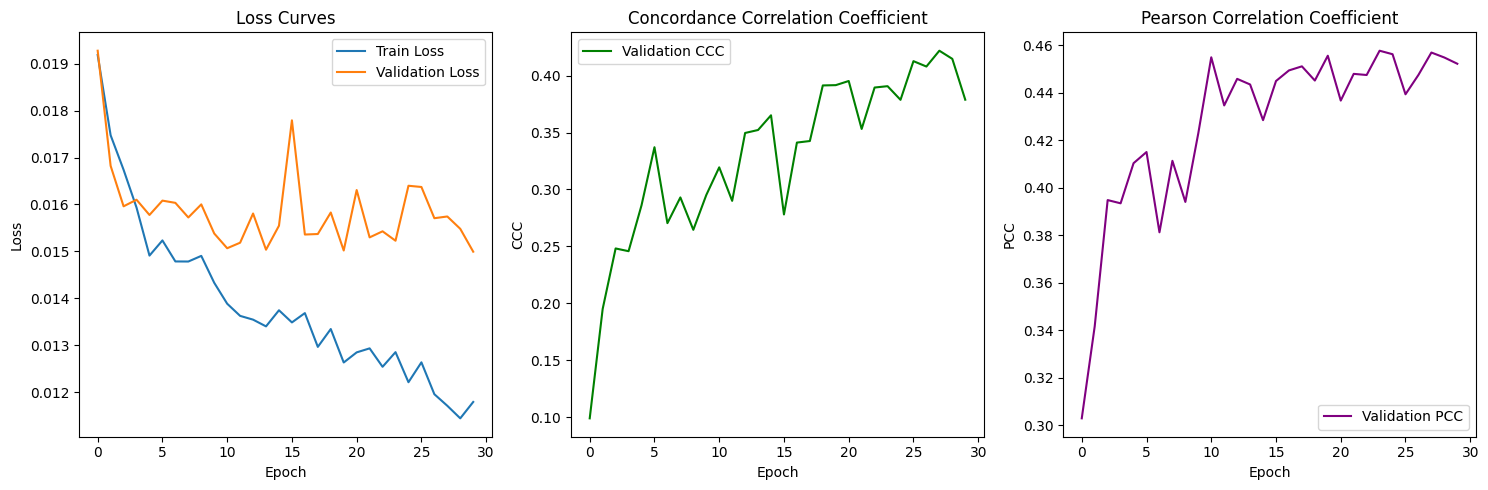

In [10]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient')

plt.tight_layout()
plt.savefig('final_training_metrics.png')
plt.show()

Loaded best model from epoch 30 with:
- Validation Loss: 0.0150
- Validation CCC: 0.3789
- Validation PCC: 0.4522
Running final evaluation on validation set...



Final Evaluation Metrics:
- MSE: 0.0150
- RMSE: 0.1224
- CCC: 0.3789
- PCC: 0.4522


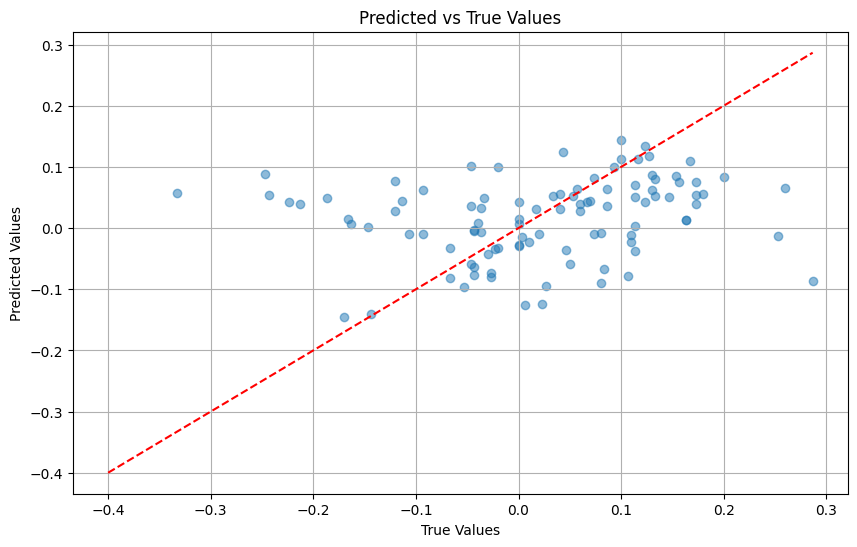

In [11]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")

# Evaluation on validation set
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            speaker_feat, listener_feat = batch["features"]
            engagement = batch["score"]
            
            speaker_feat = speaker_feat.to(device)
            listener_feat = listener_feat.to(device)
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            
            listener_feat_list = []
            for i in range(listener_feat.size(0)):
                listener_feat_list.append(listener_feat[i].transpose(0, 1))
                
            output = model(audio_paths=speaker_feat, openfacefeat_=listener_feat_list)
            
            all_preds.append(output.cpu().numpy())
            all_targets.append(engagement.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Calculate metrics
    mse = np.mean((all_targets - all_preds) ** 2)
    rmse = np.sqrt(mse)
    ccc = compute_ccc_batched(all_preds, all_targets)
    pcc = compute_pearson_correlation_batched(all_preds, all_targets)
    
    return {
        'mse': mse,
        'rmse': rmse,
        'ccc': ccc,
        'pcc': pcc,
        'predictions': all_preds,
        'targets': all_targets
    }

# Run final evaluation
print("Running final evaluation on validation set...")
eval_results = evaluate_model(model, val_loader, device)

print("\nFinal Evaluation Metrics:")
print(f"- MSE: {eval_results['mse']:.4f}")
print(f"- RMSE: {eval_results['rmse']:.4f}")
print(f"- CCC: {eval_results['ccc']:.4f}")
print(f"- PCC: {eval_results['pcc']:.4f}")

# Plot predictions vs targets for a sample
plt.figure(figsize=(10, 6))
sample_size = min(100, len(eval_results['predictions']))
indices = np.random.choice(len(eval_results['predictions']), sample_size, replace=False)

plt.scatter(eval_results['targets'][indices], eval_results['predictions'][indices], alpha=0.5)
plt.plot([min(eval_results['targets']), max(eval_results['targets'])], 
         [min(eval_results['targets']), max(eval_results['targets'])], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.grid(True)
plt.savefig('prediction_scatter.png')
plt.show()